In [33]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split

print(torch.cuda.get_device_name())
print(torch.__version__, torch.cuda.is_available())
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

NVIDIA RTX A2000 8GB Laptop GPU
2.0.0+cu118 True
cuda:0


In [17]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
x_data = np.loadtxt('../data/practice/x.csv', delimiter=',',encoding="utf-8-sig")
y_data = np.loadtxt('../data/practice/y.csv', delimiter=',',encoding="utf-8-sig")
theta_data = np.loadtxt('../data/practice/theta.csv', delimiter=',',encoding="utf-8-sig")

[[-1.95089677 -1.68718655 -0.55750106 ... 24.75735236 25.6833121
  26.85336784]
 [-1.39265343 -1.39265343 -1.32873657 ... 26.10704996 27.2326434
  28.42921012]
 [-1.76492294 -0.78487723  0.35221506 ... 27.23747789 28.22199815
  29.18854837]
 ...
 [ 3.85745585  3.85745585  4.43214483 ... 25.49375936 26.25427785
  27.59609971]
 [ 0.52651487  0.52651487  0.52651487 ... 26.97762904 28.00751776
  29.04215692]
 [ 1.85450954  1.85450954  3.10614242 ... 28.34286717 28.64772609
  30.44461778]]


In [4]:
x_data_input = np.stack([x_data[:, 0],x_data[:, -1]], axis=1)
y_data_input = np.stack([y_data[:, 0],x_data[:, -1]], axis=1)
theta_data_input = np.stack([theta_data[:, 0],x_data[:, -1]], axis=1)

x_data_output = x_data[:, 1:-1]
y_data_output = y_data[:, 1:-1]

In [5]:
input_data = np.concatenate([x_data_input, y_data_input, theta_data_input], axis=1)
output_data = np.concatenate([x_data_output, y_data_output], axis=1)

In [6]:
class MyDataset(Dataset):
    def __init__(self, input_data, output_data):
        super(MyDataset, self).__init__()
        self.input_data = input_data
        self.output_data = output_data

    def __getitem__(self, index):
        input = torch.tensor(self.input_data[index], dtype=torch.float32)
        output = torch.tensor(self.output_data[index], dtype=torch.float32)
        return input, output

    def __len__(self):
        return len(self.input_data)

In [7]:
train_valid_data = MyDataset(input_data, output_data)

val_size = 2000
train_data, val_data = torch.utils.data.random_split(train_valid_data, [len(train_valid_data)-val_size, val_size])

In [25]:
batch_size = 10

dataloader_train = torch.utils.data.DataLoader(
    train_data,
    batch_size=batch_size,
    shuffle=True
)

dataloader_valid = torch.utils.data.DataLoader(
    val_data,
    batch_size=batch_size,
    shuffle=True
)

In [46]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        return out

In [47]:
# ハイパーパラメータの設定
input_size = input_data.shape[1]
hidden_size = 2000
output_size = output_data.shape[1]
learning_rate = 0.001
num_epochs = 100

# モデルの定義
model = MLP(input_size, hidden_size, output_size).to(device)

# 損失関数の定義
criterion = nn.MSELoss()

# オプティマイザの定義
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

#トレーニングの開始
train_loss_list, val_loss_list = [], []

for epoch in range(num_epochs):
    train_loss, val_loss = 0, 0
    
    #train_mode
    model.train()
    for i, (input_data, output_data) in enumerate(dataloader_train):
        # データをGPUに転送
        input_data, output_data = input_data.to(device), output_data.to(device)
        
        # モデルの出力を計算
        output = model(input_data.view(-1, input_size))
        
        # 損失関数の適用
        loss = criterion(output, output_data)
        
        #train_lossに結果を蓄積
        train_loss += loss.item()
        
        # 勾配を初期化して逆伝播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # lossの平均を計算
        avg_train_loss = train_loss / len(dataloader_train.dataset)  
        
    #valid_mode
    model.eval()
    with torch.no_grad():
        for input_data, output_data in dataloader_valid:
            # データをGPUに転送
            input_data, output_data = input_data.to(device), output_data.to(device)
            
            # モデルの出力を計算
            output = model(input_data.view(-1, input_size))
            
            # 損失関数の適用
            loss = criterion(output, output_data)
        
            #val_lossに結果を蓄積
            val_loss += loss.item()
    
    # lossの平均を計算      
    avg_val_loss = val_loss / len(dataloader_valid.dataset)
    
    # print log
    print ('Epoch [{}/{}], Loss: {loss:.4f}, val_loss: {val_loss:.4f}'.format(epoch+1, num_epochs, i+1, loss=avg_train_loss, val_loss=avg_val_loss))
    
    # append list for polt graph after training
    train_loss_list.append(avg_train_loss)
    val_loss_list.append(avg_val_loss)



Epoch [1/100], Loss: 0.7456, val_loss: 0.4275
Epoch [2/100], Loss: 0.4157, val_loss: 0.4682
Epoch [3/100], Loss: 0.4059, val_loss: 0.3972
Epoch [4/100], Loss: 0.3980, val_loss: 0.4085
Epoch [5/100], Loss: 0.3932, val_loss: 0.3945
Epoch [6/100], Loss: 0.3900, val_loss: 0.3825
Epoch [7/100], Loss: 0.3830, val_loss: 0.3787
Epoch [8/100], Loss: 0.3831, val_loss: 0.5111
Epoch [9/100], Loss: 0.3813, val_loss: 0.3896
Epoch [10/100], Loss: 0.3798, val_loss: 0.3741
Epoch [11/100], Loss: 0.3785, val_loss: 0.4164
Epoch [12/100], Loss: 0.3775, val_loss: 0.3842
Epoch [13/100], Loss: 0.3756, val_loss: 0.3829
Epoch [14/100], Loss: 0.3779, val_loss: 0.3733
Epoch [15/100], Loss: 0.3746, val_loss: 0.3691
Epoch [16/100], Loss: 0.3745, val_loss: 0.3767
Epoch [17/100], Loss: 0.3749, val_loss: 0.4025
Epoch [18/100], Loss: 0.3732, val_loss: 0.3743
Epoch [19/100], Loss: 0.3722, val_loss: 0.3792
Epoch [20/100], Loss: 0.3734, val_loss: 0.3787
Epoch [21/100], Loss: 0.3733, val_loss: 0.3752
Epoch [22/100], Loss: 

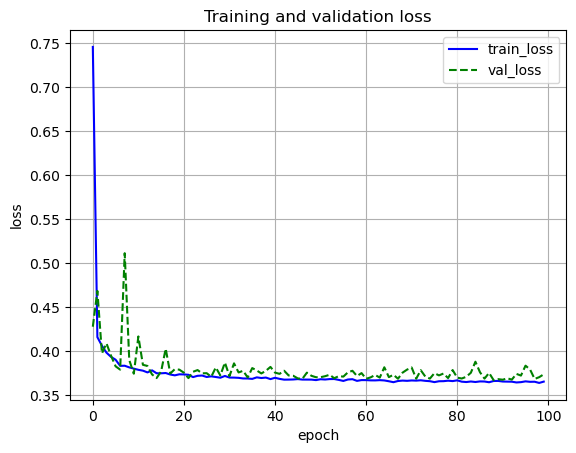

In [48]:
plt.figure()
plt.plot(range(num_epochs), train_loss_list, color='blue', linestyle='-', label='train_loss')
plt.plot(range(num_epochs), val_loss_list, color='green', linestyle='--', label='val_loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training and validation loss')
plt.grid()

In [60]:
class TestDataset(Dataset):
    def __init__(self, test_data):
        self.test_data = test_data

    def __len__(self):
        return len(self.test_data)

    def __getitem__(self, index):
        input = torch.tensor(self.test_data[index], dtype=torch.float32)
        output = 0
        return input, output

In [80]:
#test_pathの表示
import plot
import random

#入力のサンプリング
x_start = (random.uniform(-2, 4), random.uniform(-3, 3))  # Starting node
x_goal = (random.uniform(26, 32), random.uniform(-3, 3))  # Goal node

theta_start = random.uniform(-np.pi/2, np.pi/2)
theta_goal = random.uniform(-np.pi/2, np.pi/2)

test_data = np.array([[x_start[0], x_goal[0], x_start[1], x_goal[1], theta_start, theta_goal]])
print(test_data)
test_data = TestDataset(test_data)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=False)

#予測モード
model.eval()
with torch.no_grad():
    input_data, _ = next(iter(test_loader))
    input_data = input_data.to(device)
    print(input_data)
    output = model(input_data)
    print(output)
    output = output.view(2, -1)
    print(output)
    
output = output.cpu().numpy()
test_x_path = np.append(output[0], x_goal[0])
test_x_path = np.append(x_start[0], test_x_path)
test_y_path = np.append(output[1], x_goal[1])
test_y_path = np.append(x_start[1], test_y_path)

plot.vis_path(test_x_path, test_y_path)

[[ 1.96132334 28.90391172 -0.64353832  1.79213793 -0.59946176  0.30072032]]
tensor([[ 1.9613, 28.9039, -0.6435,  1.7921, -0.5995,  0.3007]],
       device='cuda:0')
tensor([[ 1.7009,  2.3601,  2.9785,  3.3639,  3.6657,  3.8624,  3.9958,  4.2861,
          4.6786,  5.0622,  5.3762,  5.6729,  5.9800,  6.2309,  6.3770,  6.5081,
          6.5126,  6.4069,  6.3740,  6.6612,  7.3206,  8.2023,  8.8470,  9.3003,
          9.4952,  9.5380,  9.6326,  9.6654, -1.9007, -2.5782, -2.7619, -2.4843,
         -2.1501, -1.8377, -1.5452, -1.2712, -1.1041, -0.9846, -0.8026, -0.6500,
         -0.4696, -0.4046, -0.3488, -0.3309, -0.2950, -0.2973, -0.3109, -0.5189,
         -0.6234, -0.6734, -0.7074, -0.5866, -0.4932, -0.4214, -0.3003, -0.0387]],
       device='cuda:0')
tensor([[ 1.7009,  2.3601,  2.9785,  3.3639,  3.6657,  3.8624,  3.9958,  4.2861,
          4.6786,  5.0622,  5.3762,  5.6729,  5.9800,  6.2309,  6.3770,  6.5081,
          6.5126,  6.4069,  6.3740,  6.6612,  7.3206,  8.2023,  8.8470,  9.3003,

TypeError: vis_path() takes 1 positional argument but 2 were given